In [1]:
# FEM numerical solution of the BVP 
# -\Delta u = 0, (x,y) \in \Omega = Cat's head
# u(left eye bdry) = 0
# u(right eye bdry = 1
# du/dn = 0 on the outer bdry

from distmesh import *
import numpy as np
import math
import matplotlib.pyplot as plt
import csv 
import scipy

[[0.86601278 0.50002187]
 [0.74993439 1.29907598]
 [0.25875807 0.96594216]]
[[-0.25890441  0.96590295]
 [-0.75013121  1.29896234]
 [-0.86608853  0.49989065]]
count =  200 displacement =  0.015608320000333376
count =  400 displacement =  0.0045811230769996734
count =  600 displacement =  0.001242787402782448
count =  800 displacement =  0.0029473421498481577


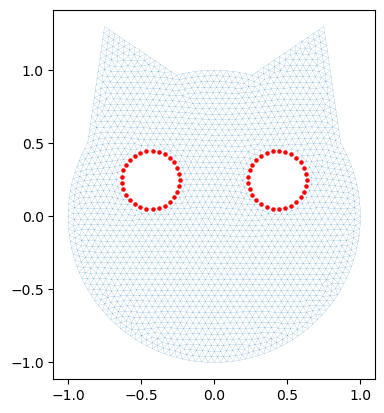

In [2]:
# trangulate Cat's head
n = 144
t = np.linspace(0,2*np.pi*(n/(n+1)),n)
rad = 1.0
h0 = rad*2*np.pi/n # the desired side of mesh triangles

pface = np.concatenate((np.reshape(rad*np.cos(t),(n,1)),np.reshape(rad*np.sin(t),(n,1))),axis = 1)

# plt.plot(pface[:,0],pface[:,1],color = "blue",label = "Cat's head")

# indexes of angle values for defining ears
j0 = int(np.round(2*n/24))
j1 = int(np.round(4*n/24))
j2 = int(np.round(5*n/24)) 
j3 = int(np.round(7*n/24))
j4 = int(np.round(8*n/24))
j5 = int(np.round(10*n/24))

# right ear
rad_ear = 1.5*rad
right_ear_tip = rad_ear*np.array([np.cos(t[j1]),np.sin(t[j1])])
right_ear = np.array([rad*np.array([np.cos(t[j0]),np.sin(t[j0])]),right_ear_tip,rad*np.array([np.cos(t[j2]),np.sin(t[j2])])])
print(right_ear)

# left ear
left_ear_tip = rad_ear*np.array([np.cos(t[j4]),np.sin(t[j4])])
left_ear = np.array([rad*np.array([np.cos(t[j3]),np.sin(t[j3])]),left_ear_tip,rad*np.array([np.cos(t[j5]),np.sin(t[j5])])])
print(left_ear)

# eyes
rad_eye_center = 0.5*rad
rad_eye = 0.2*rad

Neye = int(np.round(2*np.pi*rad_eye/h0))
t_eye = np.linspace(0,2*np.pi*(Neye-1)/Neye,Neye)
right_eye = np.concatenate((np.reshape(rad_eye_center*np.cos(t[j0])+rad_eye*np.cos(t_eye),\
                                       (Neye,1)),np.reshape(rad_eye_center*np.sin(t[j0])\
                                                            +rad_eye*np.sin(t_eye),(Neye,1))),axis = 1) 
left_eye = np.concatenate((np.reshape(rad_eye_center*np.cos(t[j5])+rad_eye*np.cos(t_eye),\
                                       (Neye,1)),np.reshape(rad_eye_center*np.sin(t[j5])\
                                                            +rad_eye*np.sin(t_eye),(Neye,1))),axis = 1) 

# fixed points of the mesh
pfix = np.concatenate((pface[0:j0+1,:],np.reshape(right_ear_tip,(1,2)),pface[j2:j3+1,:],\
                       np.reshape(left_ear_tip,(1,2)),pface[j5:n,:],right_eye,left_eye),axis = 0)

# signed distance function for Cat's head
def dfunc(p):
    d0 = dcircle(p,0.0,0.0,rad) # face
    d1 = dcircle(p,rad_eye_center*np.cos(t[j0]),rad_eye_center*np.sin(t[j0]),rad_eye) # right eye
    d2 = dcircle(p,rad_eye_center*np.cos(t[j5]),rad_eye_center*np.sin(t[j5]),rad_eye) # left eye
    d3 = dpolygon(p,left_ear,3) # left ear
    d4 = dpolygon(p,right_ear,3) # right ear
    # (face \cup left_ear \cup right_ear) \backslash (left_eye \cup right_eye) 
    d = ddiff(dunion(dunion(d0,d3),d4),dunion(d1,d2))
    return d


xmin = np.min(pfix[:,0],axis = 0)
xmax = np.max(pfix[:,0],axis = 0)
ymin = np.min(pfix[:,1],axis = 0)
ymax = np.max(pfix[:,1],axis = 0)

bbox = [xmin,xmax,ymin,ymax] # the bounding box

pts,tri = distmesh2D(dfunc,huniform,h0,bbox,pfix)
plt.scatter(right_eye[:,0],right_eye[:,1],s = 5, c = "red")
plt.scatter(left_eye[:,0],left_eye[:,1],s = 5, c = "red")


[1791 1777 1768 1740 1699 1670 1625 1581 1537 1494 1450 1422 1388 1371
 1351 1350 1370 1389 1421 1449 1493 1536 1580 1626 1669 1698 1741 1767
 1776]
[765 760 751 722 685 652 610 567 522 480 438 397 369 344 337 336 343 368
 396 437 479 521 566 611 653 686 723 750 759]


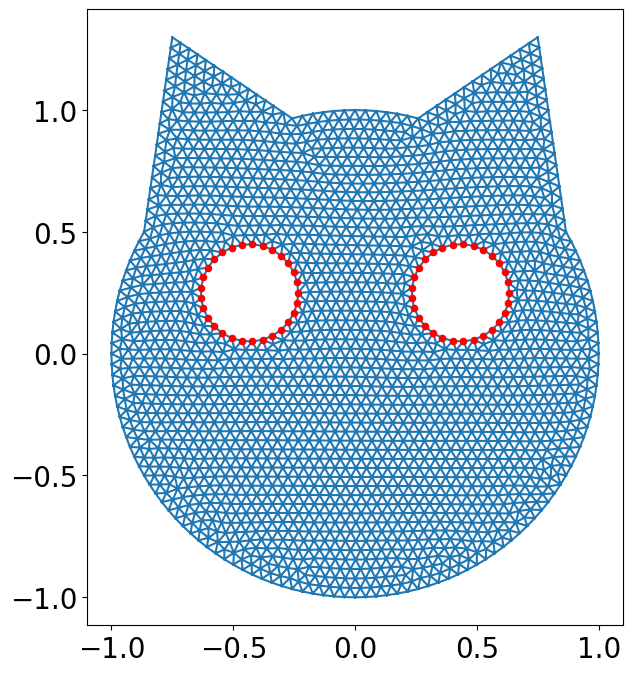

In [3]:
# find indices of mesh points on the Dirichlet boundary
right_eye_idx = []
tol = 1e-12
for j in range(Neye):
    k = np.argwhere((pts[:,0]-right_eye[j,0])**2 + (pts[:,1]-right_eye[j,1])**2 < tol)
    right_eye_idx.append(k)
right_eye_idx = np.squeeze(np.array(right_eye_idx)) 

print(right_eye_idx)

left_eye_idx = []
for j in range(Neye):    
    k = np.argwhere((pts[:,0]-left_eye[j,0])**2 + (pts[:,1]-left_eye[j,1])**2 < tol)
    left_eye_idx.append(k)
left_eye_idx = np.squeeze(np.array(left_eye_idx))

print(left_eye_idx)

dirichlet_bdry = np.concatenate((right_eye_idx,left_eye_idx))

plt.rcParams.update({'font.size': 20})
fig, ax = plt.subplots(figsize = (8,8))
plt.triplot(pts[:,0],pts[:,1],tri)    
plt.scatter(pts[dirichlet_bdry,0],pts[dirichlet_bdry,1],s=20,c="red")  
ax.set_aspect('equal')

In [4]:
# define finite element functions
def stima3(verts):
    Aux = np.ones((3,3))
    print(Aux[1:3,:])
    Aux[1:3,:] = np.transpose(verts)
    print(Aux)
    rhs = np.zeros((3,2))
    rhs[1,0] = 1
    rhs[2,1] = 1
    print(rhs)
    G = np.zeros((3,2))
    G[:,0] = np.linalg.solve(Aux,rhs[:,0])
    G[:,1] = np.linalg.solve(Aux,rhs[:,1])
    M = 0.5*np.linalg.det(Aux)*np.matmul(G,np.transpose(G))
    # print(G)
    # print(M)
    return M, G


In [5]:
verts = np.array([[0, 0],
                  [2, 0],
                  [0, 2]])
M= stima3(verts)


[[1. 1. 1.]
 [1. 1. 1.]]
[[1. 1. 1.]
 [0. 2. 0.]
 [0. 0. 2.]]
[[0. 0.]
 [1. 0.]
 [0. 1.]]


In [6]:
# test = np.array([0,2,4])
# test_t = np.array(test)[:,None]
# print("test = ",test )
# print("test_t = ",test_t)
# A = np.random.rand(5,5)
# print("A = ",A)
# print("A[test_t,test] = ",A[test_t,test])
# print("A[test,test] = ",A[test,test])

In [7]:
# FEM
Npts = np.size(pts,axis=0) # the number of mesh points
Ntri = np.size(tri,axis=0) # the number of triangle
print("Npts = ",Npts," Ntri = ",Ntri)

free_nodes = np.setdiff1d(np.arange(0,Npts,1,dtype = int),dirichlet_bdry,assume_unique=True)

A = scipy.sparse.csr_matrix((Npts,Npts), dtype = float).toarray() # define the sparse matrix A
b = np.zeros((Npts,1)) # the right-hand side
u = np.zeros((Npts,1)) # the solution
u[right_eye_idx] = 1 # define u at known values

# stiffness matrix
for j in range(Ntri):
    v = pts[tri[j,:],:] # vertices of mesh triangle
    ind = tri[j,:]
    indt = np.array(ind)[:,None]
    B = scipy.sparse.csr_matrix((3,3),dtype = float).toarray()
    A[indt,ind] = A[indt,ind] + stima3(v)[0]

# load vector
b = b - np.matmul(A,u)

# solve for committor
free_nodes_t = np.array(free_nodes)[:,None]
u[free_nodes] = scipy.linalg.solve(A[free_nodes_t,free_nodes],b[free_nodes])
u = np.reshape(u,(Npts,))

Npts =  2123  Ntri =  4019
[[1. 1. 1.]
 [1. 1. 1.]]
[[ 1.          1.          1.        ]
 [-0.91998502 -0.93374827 -0.88869214]
 [ 0.27150109  0.23276224  0.24449369]]
[[0. 0.]
 [1. 0.]
 [0. 1.]]
[[1. 1. 1.]
 [1. 1. 1.]]
[[ 1.          1.          1.        ]
 [-0.97632651 -0.98483259 -0.94484215]
 [ 0.21630196  0.17350726  0.19163695]]
[[0. 0.]
 [1. 0.]
 [0. 1.]]
[[1. 1. 1.]
 [1. 1. 1.]]
[[ 1.          1.          1.        ]
 [-0.93374827 -0.97632651 -0.94484215]
 [ 0.23276224  0.21630196  0.19163695]]
[[0. 0.]
 [1. 0.]
 [0. 1.]]
[[1. 1. 1.]
 [1. 1. 1.]]
[[ 1.          1.          1.        ]
 [ 0.95786067  0.9990613   1.        ]
 [-0.02107487 -0.04331875  0.        ]]
[[0. 0.]
 [1. 0.]
 [0. 1.]]
[[1. 1. 1.]
 [1. 1. 1.]]
[[ 1.          1.          1.        ]
 [ 0.9990613   0.9646654   0.9962207 ]
 [-0.04331875 -0.06184308 -0.08685806]]
[[0. 0.]
 [1. 0.]
 [0. 1.]]
[[1. 1. 1.]
 [1. 1. 1.]]
[[ 1.          1.          1.        ]
 [ 0.95786067  0.9646654   0.9990613 ]
 [-0.02107487 -

[(-1.0, 1.0), (-1.0, 1.5)]

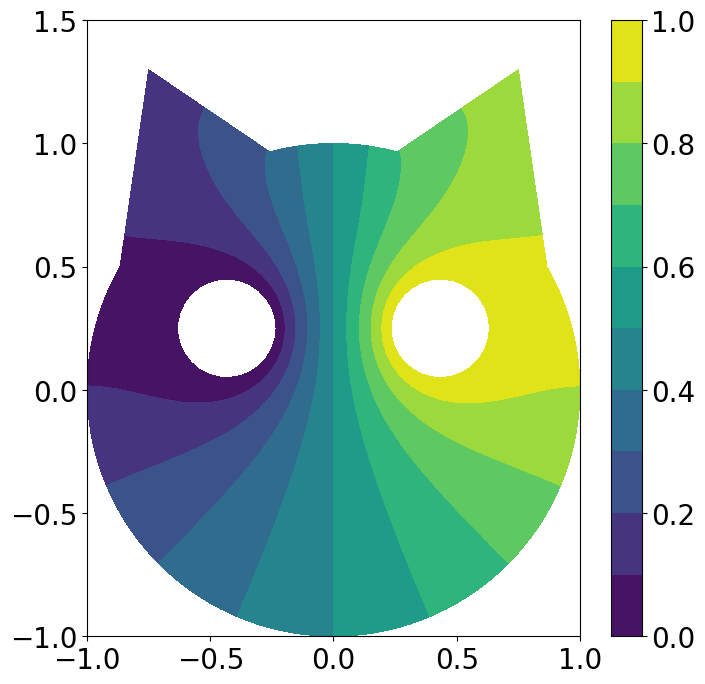

In [8]:
# visualization
plt.rcParams.update({'font.size': 20})
fig, ax = plt.subplots(figsize = (8,8))
plt.tricontourf(pts[:,0], pts[:,1],tri,u,np.arange(0,1.1,0.1))
plt.colorbar()
ax.set_aspect('equal')
ax.set(xlim=(-rad,rad), ylim=(-rad,rad_ear)) 

count =  200 displacement =  0.022390634443540437
count =  400 displacement =  0.0056747176461715105


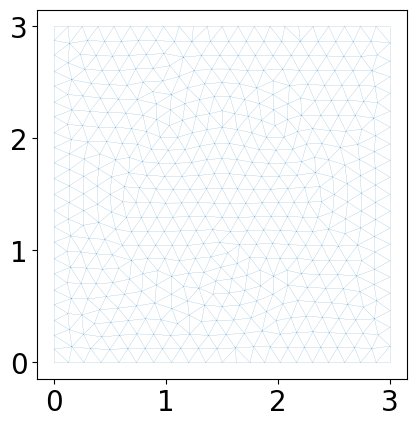

In [9]:
def dfunc(p):
    return drectangle(p, 0, 3, 0, 3)

# 圆边界点（导电率界面）
theta = np.linspace(0, 2*np.pi, 40, endpoint=False)
circle = np.vstack((1.5 + np.cos(theta), 1.5 + np.sin(theta))).T

# 方形边界点
square = np.array([[0,0],[3,0],[3,3],[0,3],[0,1.5],[3,1.5],[1.5,0],[1.5,3]])

pfix = np.vstack((circle, square))

pts, tri = distmesh2D(dfunc, huniform, h0=0.15, bbox=[0, 3, 0, 3], pfix=pfix)



In [10]:
centers = (pts[tri[:,0]] + pts[tri[:,1]] + pts[tri[:,2]]) / 3
in_circle = np.linalg.norm(centers - np.array([1.5, 1.5]), axis=1) <= 1.0
a = np.where(in_circle, 1.0, 1.2)  # 或 0.8

tol = 1e-6
left_bdry = np.where(np.abs(pts[:,0] - 0) < tol)[0]
right_bdry = np.where(np.abs(pts[:,0] - 3) < tol)[0]

u = np.zeros(len(pts))
u[right_bdry] = 1.0  # 设置右边为 1

dirichlet = np.concatenate((left_bdry, right_bdry))
free_nodes = np.setdiff1d(np.arange(len(pts)), dirichlet)



In [11]:
from scipy.sparse import lil_matrix

A = lil_matrix((len(pts), len(pts)))
b = np.zeros(len(pts))

for i in range(len(tri)):
    indices = tri[i]
    v = pts[indices]
    Ke = a[i] * stima3(v)[0]  # stima3 返回 (M, G)，取 M
    for ii in range(3):
        for jj in range(3):
            A[indices[ii], indices[jj]] += Ke[ii, jj]


[[1. 1. 1.]
 [1. 1. 1.]]
[[1.         1.         1.        ]
 [2.8661251  3.         2.85966386]
 [1.73525448 1.8040489  1.88182612]]
[[0. 0.]
 [1. 0.]
 [0. 1.]]
[[1. 1. 1.]
 [1. 1. 1.]]
[[1.         1.         1.        ]
 [3.         3.         2.85966386]
 [1.8040489  1.95060559 1.88182612]]
[[0. 0.]
 [1. 0.]
 [0. 1.]]
[[1. 1. 1.]
 [1. 1. 1.]]
[[1.         1.         1.        ]
 [3.         2.8661251  3.        ]
 [1.8040489  1.73525448 1.65344488]]
[[0. 0.]
 [1. 0.]
 [0. 1.]]
[[1. 1. 1.]
 [1. 1. 1.]]
[[1.         1.         1.        ]
 [2.85966386 2.86833008 2.71145774]
 [1.88182612 2.02356808 1.9471238 ]]
[[0. 0.]
 [1. 0.]
 [0. 1.]]
[[1. 1. 1.]
 [1. 1. 1.]]
[[1.         1.         1.        ]
 [3.         2.86833008 2.85966386]
 [1.95060559 2.02356808 1.88182612]]
[[0. 0.]
 [1. 0.]
 [0. 1.]]
[[1. 1. 1.]
 [1. 1. 1.]]
[[ 1.00000000e+00  1.00000000e+00  1.00000000e+00]
 [ 1.30126446e-01 -6.26600334e-13  0.00000000e+00]
 [-1.15477766e-12  1.20164050e-01  0.00000000e+00]]
[[0. 0.]
 [

In [12]:
from scipy.sparse.linalg import spsolve

b = b - A.dot(u)  # 考虑边界对右边的影响
u[free_nodes] = spsolve(A[free_nodes, :][:, free_nodes], b[free_nodes])


j = np.zeros((len(tri), 2))  # 每个三角形中心的 j 向量

for i in range(len(tri)):
    verts = pts[tri[i]]
    M, G = stima3(verts)
    u_tri = u[tri[i]]
    grad_u = G.T @ u_tri  # shape: (2,)
    j[i] = -a[i] * grad_u

j_magnitude = np.linalg.norm(j, axis=1)


[[1. 1. 1.]
 [1. 1. 1.]]
[[1.         1.         1.        ]
 [2.8661251  3.         2.85966386]
 [1.73525448 1.8040489  1.88182612]]
[[0. 0.]
 [1. 0.]
 [0. 1.]]
[[1. 1. 1.]
 [1. 1. 1.]]
[[1.         1.         1.        ]
 [3.         3.         2.85966386]
 [1.8040489  1.95060559 1.88182612]]
[[0. 0.]
 [1. 0.]
 [0. 1.]]
[[1. 1. 1.]
 [1. 1. 1.]]
[[1.         1.         1.        ]
 [3.         2.8661251  3.        ]
 [1.8040489  1.73525448 1.65344488]]
[[0. 0.]
 [1. 0.]
 [0. 1.]]
[[1. 1. 1.]
 [1. 1. 1.]]
[[1.         1.         1.        ]
 [2.85966386 2.86833008 2.71145774]
 [1.88182612 2.02356808 1.9471238 ]]
[[0. 0.]
 [1. 0.]
 [0. 1.]]
[[1. 1. 1.]
 [1. 1. 1.]]
[[1.         1.         1.        ]
 [3.         2.86833008 2.85966386]
 [1.95060559 2.02356808 1.88182612]]
[[0. 0.]
 [1. 0.]
 [0. 1.]]
[[1. 1. 1.]
 [1. 1. 1.]]
[[ 1.00000000e+00  1.00000000e+00  1.00000000e+00]
 [ 1.30126446e-01 -6.26600334e-13  0.00000000e+00]
 [-1.15477766e-12  1.20164050e-01  0.00000000e+00]]
[[0. 0.]
 [

/var/folders/8h/3f67brv57394lw2cy4zl861c0000gn/T/ipykernel_66316/3543288432.py:4: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  u[free_nodes] = spsolve(A[free_nodes, :][:, free_nodes], b[free_nodes])


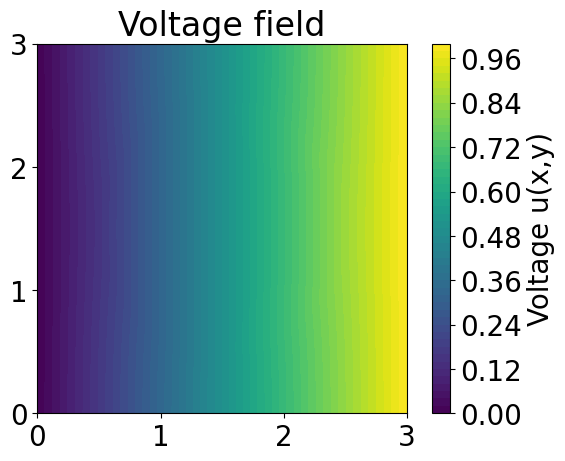

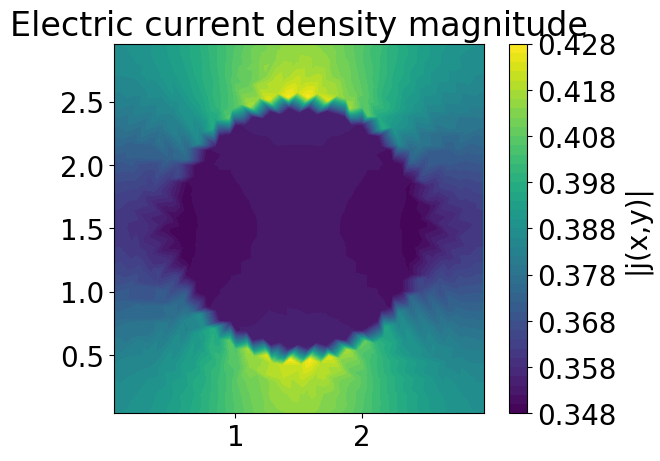

In [13]:
import matplotlib.pyplot as plt

plt.figure()
plt.tricontourf(pts[:,0], pts[:,1], tri, u, levels=50)
plt.colorbar(label='Voltage u(x,y)')
plt.gca().set_aspect('equal')
plt.title("Voltage field")
plt.show()

plt.figure()
plt.tricontourf(centers[:,0], centers[:,1], j_magnitude, levels=50)
plt.colorbar(label='|j(x,y)|')
plt.gca().set_aspect('equal')
plt.title("Electric current density magnitude")
plt.show()


count =  200 displacement =  0.008120744706633794
count =  400 displacement =  0.004589570700832592
tri.shape: (2072, 3)
first few tri rows: [[ 11   2   0]
 [ 14   2  11]
 [ 42  22  29]
 [549 535 562]
 [367 402 386]]
filtered tri.shape: (2072, 3)


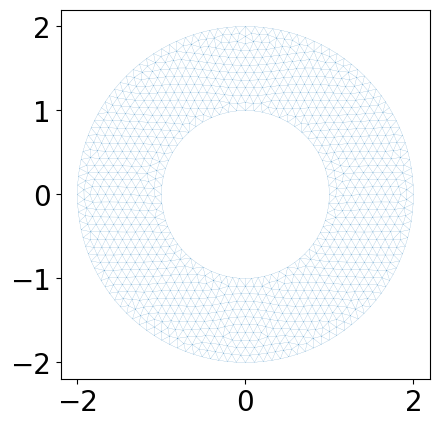

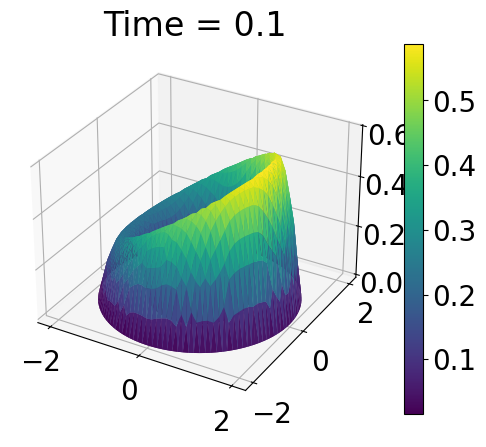

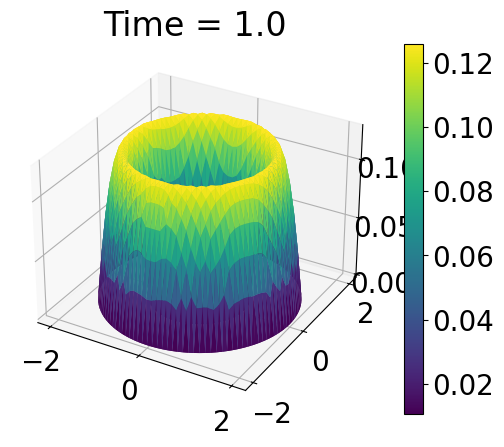

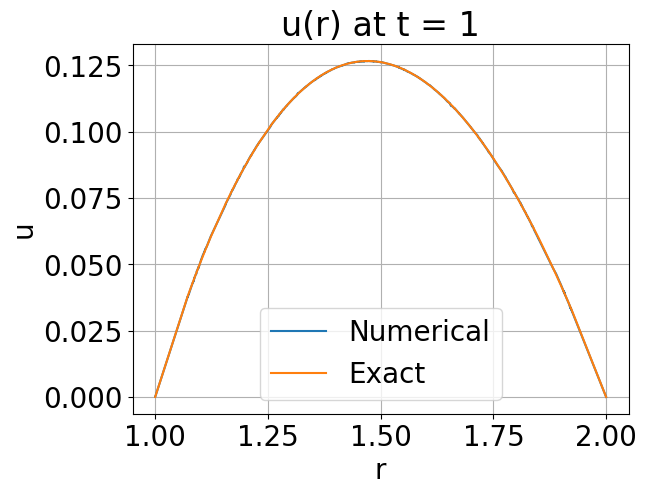

In [23]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse as sp
import scipy.sparse.linalg

from distmesh import distmesh2D, huniform, dcircle, ddiff

# Step 1: Create mesh (annulus)
fd = lambda p: ddiff(dcircle(p, 0, 0, 2), dcircle(p, 0, 0, 1))
bbox = np.array([-2, 2, -2, 2])
h0 = 0.1
theta = np.linspace(0, 2*np.pi, 20, endpoint=False)
circle1 = np.stack((np.cos(theta), np.sin(theta)), axis=1) * 1
circle2 = np.stack((np.cos(theta), np.sin(theta)), axis=1) * 2
pfix = np.vstack((circle1, circle2))
pts, tri = distmesh2D(fd, huniform, h0, bbox, pfix)

tri = np.asarray(tri)

# 打印调试信息（确认维度）
print("tri.shape:", tri.shape)
print("first few tri rows:", tri[:5])

# 如果 tri 中有不是 3 个点的条目（例如只包含 2 个点的边），需要删掉
tri = np.array([t for t in tri if len(t) == 3 and np.array(t).shape == (3,)])

# 再次确认过滤后的 tri 没问题
print("filtered tri.shape:", tri.shape)

# Step 2: Identify boundary nodes
eps = 1e-4
r = np.sqrt(pts[:, 0]**2 + pts[:, 1]**2)
dirichlet1 = np.where(np.abs(r - 1) < eps)[0]
dirichlet2 = np.where(np.abs(r - 2) < eps)[0]
dirichlet = np.concatenate((dirichlet1, dirichlet2))
free_nodes = np.setdiff1d(np.arange(len(pts)), np.unique(dirichlet))

# Step 3: Initialize FEM variables
Npts = len(pts)
Ntri = len(tri)
T = 1.0
dt = 0.01
N = int(T / dt)
U = np.zeros((Npts, N+1))

# Step 4: Assemble A (stiffness) and B (mass) matrices
def stima3(vertices):
    """
    Computes the element stiffness matrix for a triangle.
    Input:
        vertices: (3, 2) array of triangle vertex coordinates
    Output:
        (3, 3) local stiffness matrix
    """
    B = np.ones((3, 3))
    B[:, 1:] = vertices
    area = 0.5 * abs(np.linalg.det(B))
    C = np.linalg.inv(B)
    grads = C[1:, :]
    return area * (grads.T @ grads)

A = sp.lil_matrix((Npts, Npts))
B = sp.lil_matrix((Npts, Npts))

for j in range(Ntri):
    idx = tri[j]
    verts = pts[idx]
    area = abs(np.linalg.det(np.vstack([np.ones(3), verts.T]))) / 2
    localA = stima3(verts)
    localB = area * np.array([[2, 1, 1], [1, 2, 1], [1, 1, 2]]) / 24
    for a in range(3):
        for b in range(3):
            A[idx[a], idx[b]] += localA[a, b]
            B[idx[a], idx[b]] += localB[a, b]

# Step 5: Initial condition
def IC(x):
    r = np.sqrt(x[:, 0]**2 + x[:, 1]**2)
    return r + x[:, 0] / r

U[:, 0] = IC(pts)

# Step 6: Time evolution
def myf(x, t):
    return np.ones(x.shape[0])

def myu_d(x, t):
    return np.zeros(x.shape[0])

for n in range(1, N+1):
    t = n * dt
    b = np.zeros(Npts)
    for j in range(Ntri):
        idx = tri[j]
        centroid = np.mean(pts[idx], axis=0)
        area = abs(np.linalg.det(np.vstack([np.ones(3), pts[idx].T]))) / 2
        b[idx] += area * dt * myf(np.array([centroid]), t) / 3

    b += (-0.5 * dt * A + B) @ U[:, n-1]
    u = np.zeros(Npts)
    u[dirichlet] = myu_d(pts[dirichlet], t)
    b -= (0.5 * dt * A + B) @ u
    u[free_nodes] = sp.linalg.spsolve(0.5 * dt * A[free_nodes][:, free_nodes] + B[free_nodes][:, free_nodes], b[free_nodes])
    U[:, n] = u

    if np.isclose(t, 0.1) or np.isclose(t, 1.0):
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        ax.plot_trisurf(pts[:, 0], pts[:, 1], u, triangles=tri, cmap='viridis')
        ax.set_title(f"Time = {t:.1f}")
        plt.colorbar(ax.plot_trisurf(pts[:, 0], pts[:, 1], u, triangles=tri, cmap='viridis'), ax=ax)
        plt.show()

        if np.isclose(t, 1.0):
            r_sorted = np.sort(np.sqrt(pts[:, 0]**2 + pts[:, 1]**2))
            u_sorted = u[np.argsort(np.sqrt(pts[:, 0]**2 + pts[:, 1]**2))]
            plt.plot(r_sorted, u_sorted, label="Numerical")
            true = (1 - r_sorted**2) / 4 + 3 * np.log(r_sorted) / (4 * np.log(2))
            plt.plot(r_sorted, true, label="Exact")
            plt.legend()
            plt.title("u(r) at t = 1")
            plt.xlabel("r")
            plt.ylabel("u")
            plt.grid(True)
            plt.show()
